## Quantum Coinflip
The aim of this notebook is for me to get used to quantum circuits, qubits and IBM's Quantum Computing service. I am not an expert, and mainly using this to consolidate my learning.

### 1. Dependencies

In [2]:
import os
import sys
from dotenv import load_dotenv
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Pauli
from qiskit.primitives import (BackendEstimatorV2, BackendSamplerV2)
from qiskit_aer.backends.compatibility import Statevector

### 2. Hadamard Gate
To do a coinflip I want to place a single qubit in an equal superposition of $|0\rangle$ and $|1\rangle$, so that when measured there is a 50-50 probability of being in either state. The easiest way to do that is to apply a Hadamard gate to the initial state $|0\rangle$ so that $|\psi\rangle = |0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + |1|\rangle)$.

The Hadamard gate corresponds to a $\pi$ rotation around the X+Z axis, and has the effect of changing the compuational basis so that:
   - $|0\rangle \leftrightarrow |+\rangle = \frac{1}{\sqrt(2)}(|0\rangle + |1\rangle)$.
   - $|1\rangle \leftrightarrow |-\rangle = \frac{1}{\sqrt(2)}(|0\rangle - |1\rangle)$.

Applying the Hadamard gate again changes the computational basis back. I think these transitions will help visualise what is going on. The circuit simply needs to be a Hadamard gate on one qubit, followed by a measurement onto a classical register.

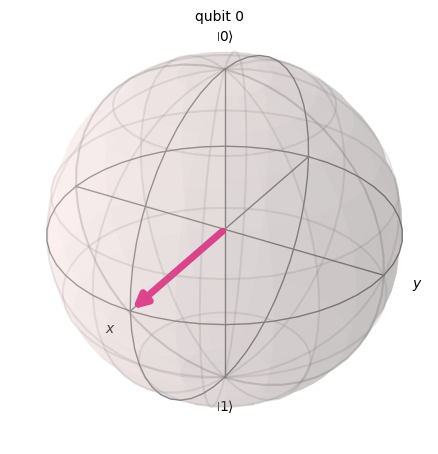

In [17]:
# create quantum circuit
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
Statevector(qc).draw('bloch')

On the Bloch sphere it is easy to see that the qubit is placed equally between $|0\rangle$ and $|1\rangle$ (on the z-axis). Now I can measure the qubit, and run the circuit on a backend. I will simulate a backend for now, just to make sure everything is working. 

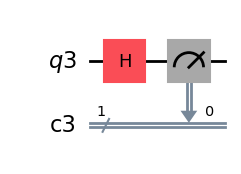

In [18]:
# measure
qc.measure(q0, c0)
qc.draw('mpl')

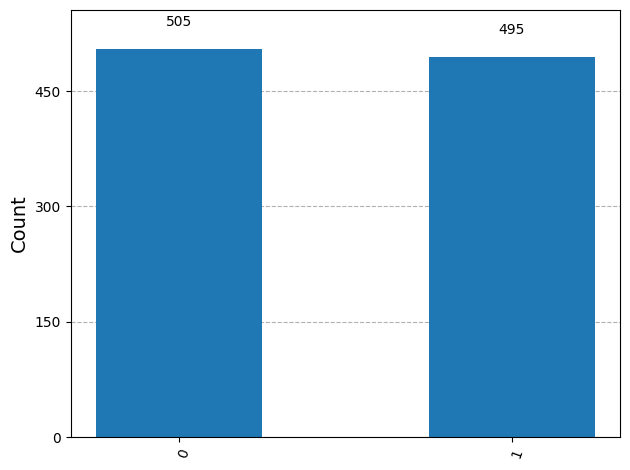

In [20]:
# Run a quick test of the circuit on a simulated backend.
backend = Aer.get_backend('qasm_simulator')
qc = transpile(qc, backend)
job = backend.run(qc, shots=1000)
result = job.result().get_counts()
plot_histogram(result)

Success! Over 1000 simulations of the circuit, we get roughly balanced outcomes of $|0\rangle$ and $|1\rangle$.

If we apply another Hadamard gate before measuring, we should, in theory, get all $|0\rangle$ outcomes as the second gate brings us back to that basis.

($|0\rangle \rightarrow |+\rangle \rightarrow |0\rangle$).

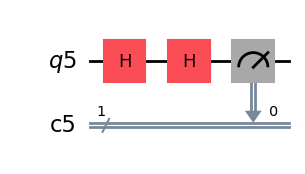

In [22]:
# Generate a new circuit with two hadamard gates.
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
qc.h(q0)
qc.measure(q0,c0)
qc.draw('mpl')

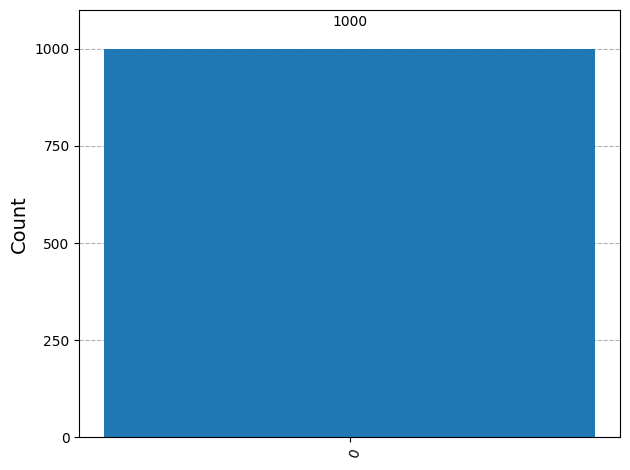

In [23]:
qc = transpile(qc, backend)
job = backend.run(qc, shots=1000)
result = job.result().get_counts()
plot_histogram(result)

Good stuff! Basics managed.
### 3. Sampler primitive on IBM's backend
Now I want to run this basic circuit on real hardware. Qiskit's documentation make this a relatively painless process. I will do the following:
 - Connect to IBM's quantum service using my API, and instance CRN.
  - Pick backend hardware to use, ideally the least busy open quantum computer.
  - Reframe circuit so that it can be used by the backend.
  - Run circuit on backend.

I built a separate Script to connect to IBM's runtime service, just because I thought I would be using it quite a lot. It connects me to the least busy service. I get the API token and instance separately as I need them to fetch data from the service down the line.

In [3]:
# Fetch API token and instance CRN. Stored locally in a .env file and not pushed, for obvious reasons.
load_dotenv()
API_TOKEN = os.getenv('API_TOKEN')
CRN = os.getenv('CRN')

In [4]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.ibmq_connect import ibmq_connect_least_busy
backend = ibmq_connect_least_busy(API_TOKEN, CRN)

qiskit_runtime_service._discover_account:WARNING:2025-11-07 18:25:56,980: Loading account with the given token. A saved account will not be used.


Name: ibm_fez
Version: 2
No. of qubits: 156



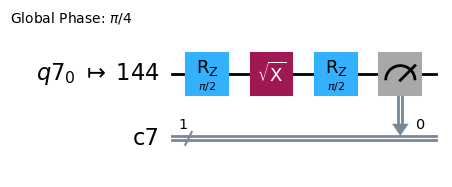

In [27]:
# create quantum circuit
q0 = QuantumRegister(1)
c0 = ClassicalRegister(1)
qc = QuantumCircuit(q0, c0)
qc.h(q0)
qc.measure(q0, c0)

# Transpile circuit into something interpretable by the chosen quantum backend
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3) # this is the transpiler
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

Above is the transposition of the circuit. A phase rotation of $\pi/2$, followed by a Sqrt(X) gate, and another $\pi/2$ rotation.

The Sqrt(X) gate is a half-NOT gate - applying this twice would get the single NOT gate. So the Sqrt(X) rotates the qubit $\pi/2$ around the x-axis, much like half flipping a coin so that it stands on it's side. I think this makes some sense when thinking about the corresponding movement on the Bloch sphere, but would like to look at it further.

Below is the execution of the circuit on the backend chosen above. There seem to be two ways of executing a quantum circuit on hardware, being the Sampler and Estimator primitives. My understanding is that primitives are a high-abstraction interface that allow us to run Quantum Computing tasks without getting bogged down in the nitty gritty of error correction, backend parameters etc.

The Sampler primitive runs the circuit and samples the classical registers. My main goal at the moment is to simply count the number of times the circuit returns $|0\rangle$, and $|1\rangle$, so this seems appropriate. 

In [65]:
# ## Run sample 1000 times on hardware
# sampler = Sampler(mode=backend)
# pubs = [qc_isa]
# job = sampler.run(pubs, shots=1000)
# res = job.result()

To save computation time on the service, I can fetch the results instead of waiting in a queue again.

In [28]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45c4bd63mfc73a6rqs0')
job_result = job.result()

qiskit_runtime_service._discover_account:WARNING:2025-11-06 23:48:18,834: Loading account with the given token. A saved account will not be used.


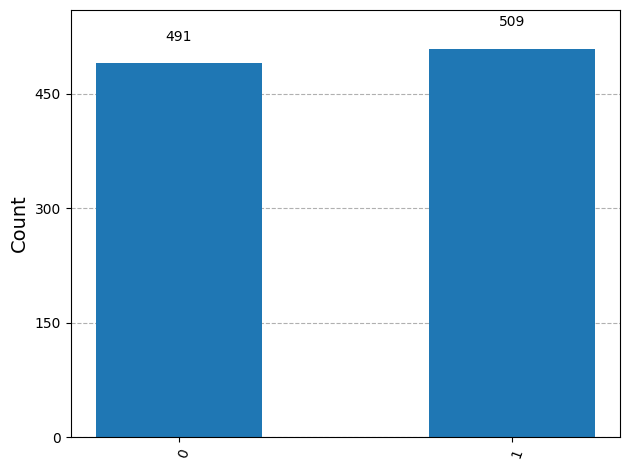

In [29]:
# Plot histogram of resulting states.
pub_result = job_result[0].data.c1.get_counts()
plot_histogram(pub_result)

Looks an even split, up to some statistical fluctuation.

### 4. Estimator
An estimator calculates the expected value of an observable with respect to a quantum state. We sample by measuring in the z-basis, so it seems natural to try an estimate in that basis also. For this I will use the Pauli '$Z$' matrix. The expected value of this is:

$E(Z) = \langle \psi | Z | \psi \rangle = \frac{1}{2} \langle 0 | Z | 0 \rangle + \frac{1}{2} \langle 1 | Z | 1 \rangle = \frac{1}{2}(+1) + \frac{1}{2}(-1) = 0$.


In [30]:
# Create coinflip circuit. No measuring needed so no classical register.
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)

# Transpile
obs = Pauli('Z')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

In [31]:
print('Simulated E[Z] = ', res[0].data.evs)

Simulated E[Z] =  0.0185546875


Gives a good result on the simulator, so we can try on the real deal. 

In [198]:
## Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [32]:
# Fetch result from IBM service
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45p8l6n7jjs73bst07g')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-07 00:05:22,243: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: -0.000493339911198816


Great! This was the expected result: the coinflip is expected to be 50-50 when estimating observable $Z$.

What about estimating in other basis. Since the Hadamard gate is a rotation around the X+Z axis, I want to try estimating in the X axis. For this I will use the Pauli X (NOT) gate. On the IBM qiskit learning site, they describe this as estimating 'heads left or right' rather than 'heads up or down'. The NOT gate applied to the new computational basis states gives

 - $X|+\rangle = |+\rangle \implies \langle+|X|+\rangle = \langle+||+\rangle = +1$
 - $X|-\rangle = -|-\rangle \implies \langle-|X|-\rangle = -\langle-||-\rangle = -1$

If $|\psi\rangle$ was equally placed between these states I would expect a value of 0. However, the coinflip circuit applies a Hadamard gate to $|0\rangle$ yielding $|+\rangle$, so instead I expect a value of +1.

In [194]:
# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

Simulated E[X] =  0.9892578125


In [195]:
# # Run on hardware
# estimator = Estimator(mode=backend)
# pubs = [(qc_isa, qc_obs)]
# job = estimator.run([[qc_isa, qc_obs]])
# res = job.result()

In [197]:
service = QiskitRuntimeService(
    token=API_TOKEN,
    channel='ibm_quantum_platform',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/4428e288f1c84a85b2b691eeca5246ba:88d9dc6b-3276-44dc-a866-84c34964d056::'
)
job = service.job('d45rj7ejf4ms73ap36kg')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

qiskit_runtime_service._discover_account:WARNING:2025-11-05 20:57:09,634: Loading account with the given token. A saved account will not be used.


Expectation values for pub 0: 1.0


We get an expected value of +1, as predicted. I think this is mainly down to the phase of the qubit. If I phase rotate by $\pi/2$ around the Z-axis, it should now equally superposition between $|+\rangle$ and $|-\rangle$. Let's see.

In [206]:
# Create new coinflip circuit
q_e = QuantumRegister(1)
qc_e = QuantumCircuit(q_e)
qc_e.h(q_e)
qc_e.p(np.pi/2, q_e)

# Transpile
obs = Pauli('X')
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc_e)
qc_obs = obs.apply_layout(qc_isa.layout) # observation matrix

# Run the job on the Aer simulator with noise model from real backend
backend_sim = AerSimulator.from_backend(backend)
estimator_sim = BackendEstimatorV2(backend=backend_sim)
job = estimator_sim.run([[qc_isa, qc_obs]])
res=job.result()

print('Simulated E[X] = ', res[0].data.evs)

Simulated E[X] =  -0.017578125


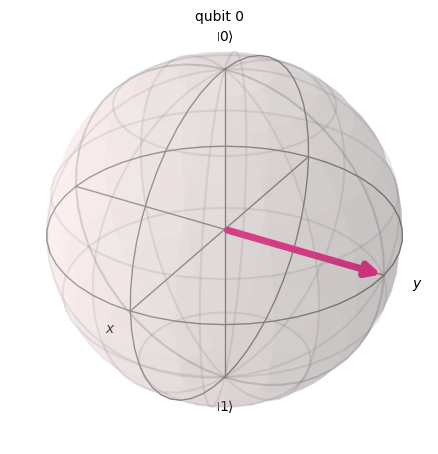

In [209]:
Statevector(qc_e).draw('bloch')

Looking at the Bloch Sphere, we can see that with the phase rotation the qubit is now 'balanced' in the x-axis and the z-axis, though not the y-axis. The expected value is pretty much 0 so the phase rotation seems to have worked.
### 5. Weighted Coinflip
I want to manipulate the amplitudes so that when measuring in the z-basis I have a biased 75:25 split.

This looks like $|\psi\rangle = \sqrt{0.75} |0\rangle + \sqrt{0.25} |1\rangle$. Trigonometry on the bloch sphere tells us $|\psi\rangle = cos \frac{\theta}{2} |0\rangle + e^{i\phi} sin \frac{\theta}{2} |1\rangle$. So we have

 - $cos \theta/2 = \sqrt{3}/2$,
 - $sin \theta/2 = 1/2$.

Therefore $\theta = \pi/3$. Implementing this rotation inbetween two Hadamard gates should give the desired rotation around the y-axis. I will try this out:

In [33]:
# Create new coinflip circuit
q = QuantumRegister(1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(q, cr)
qc.h(q)
qc.p(np.pi/3, q) # phase rotation of theta
qc.h(q)
qc.measure_all()

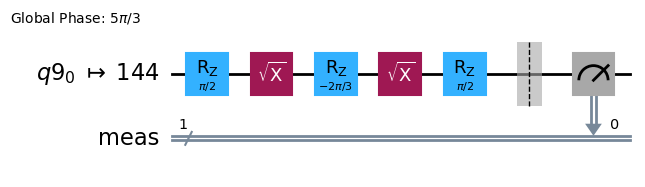

In [34]:
# Transpile
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qc)
qc_isa.draw('mpl')

In [37]:
backend_sim = AerSimulator.from_backend(backend)
sampler_sim = BackendSamplerV2(backend=backend_sim)
job = sampler_sim.run([[qc_isa]], shots = 1000)
res = job.result()
# counts=job.result()[0].data.meas.get_counts()

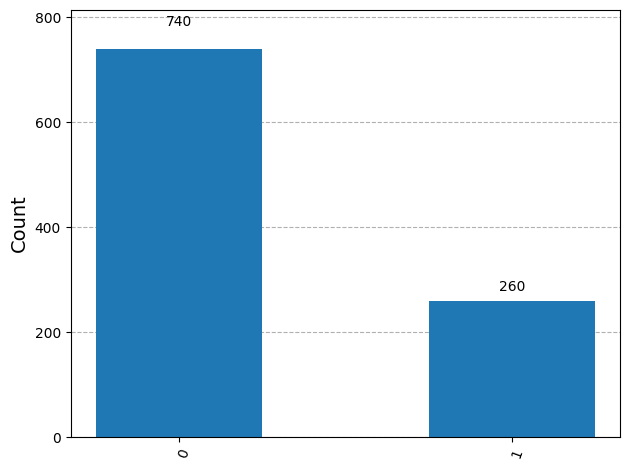

In [38]:
plot_histogram(res[0].data.meas.get_counts())

Success!